In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm.notebook import tqdm

from sklearn.metrics import log_loss, accuracy_score, classification_report, plot_confusion_matrix, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import BatchNormalization, LayerNormalization
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [2]:
history = pd.DataFrame(
    [],
    columns=pd.MultiIndex.from_product([['train', 'validate'], ['logloss', 'accuracy']]),
    dtype='float32'
)

def plot_confusion_matrix_keras(model, x, y, display_labels=None, values_format='d', cmap='Blues'):
    classes = np.unique(y)
    if display_labels is None:
        display_labels = list(classes)
    d = []
    for cls in classes:
        predictions = model.predict_classes(x[y==cls])
        d.append([np.count_nonzero(predictions==subcls) for subcls in classes])
    d = np.asarray(d)
    sns.heatmap(
        d, cmap=cmap, fmt=values_format,
        annot=True, square=True, xticklabels=display_labels, yticklabels=display_labels
    )
    plt.xlabel('Predicted label')
    plt.ylabel('Truth label')

def evaluate_model(clf, slug, xtrain, ytrain, xvalid, yvalid, fit=True):
    global history
    if fit:
        clf.fit(xtrain, ytrain)

    # print loss values
    predictions = clf.predict_proba(xtrain)
    print ("train set: logloss: %0.3f" % (log_loss(ytrain, predictions), ))
    history.loc[slug, ('train', 'logloss')] = log_loss(ytrain, predictions)
    predictions = clf.predict_proba(xvalid)
    print ("valid set: logloss: %0.3f" % (log_loss(yvalid, predictions), ))
    history.loc[slug, ('validate', 'logloss')] = log_loss(yvalid, predictions)
    
    # print accuracy matrix
    predictions = clf.predict_classes(xtrain)
    print('train set')
    print(classification_report(ytrain, predictions, target_names=lbl_enc.classes_, digits=3))
    print('-' * 70)
    predictions = clf.predict_classes(xvalid)
    print('validate set')
    print(classification_report(yvalid, predictions, target_names=lbl_enc.classes_, digits=3))

    plot_confusion_matrix_keras(clf, xvalid, yvalid, display_labels=lbl_enc.classes_, values_format='d', cmap='Blues')
    plt.grid(False)
    
    history.loc[slug, ('train', 'accuracy')] = balanced_accuracy_score(ytrain, clf.predict_classes(xtrain))
    history.loc[slug, ('validate', 'accuracy')] = balanced_accuracy_score(yvalid, clf.predict_classes(xvalid))

In [4]:
def plot_keras_history(history):
    plt.figure(figsize=(14, 7))
    # Plot training & validation accuracy values
    plt.subplot(121)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validate'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validate'], loc='upper left')

    plt.show()
    


In [5]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sample = pd.read_csv('../input/sample_submission.csv')

In [6]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(train.author.values)
xtrain, xvalid, ytrain, yvalid = train_test_split(train.text.values, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

In [7]:
# we need to binarize the labels for the neural net
ytrain_enc = utils.to_categorical(ytrain)
yvalid_enc = utils.to_categorical(yvalid)
pd.DataFrame({
    'author': np.asarray(lbl_enc.classes_)[ytrain],
    'label': ytrain,
    'encoded': ytrain_enc.tolist()
}).head()

,author,label,encoded
0,MWS,2,"[0.0, 0.0, 1.0]"
1,EAP,0,"[1.0, 0.0, 0.0]"
2,MWS,2,"[0.0, 0.0, 1.0]"
3,HPL,1,"[0.0, 1.0, 0.0]"
4,MWS,2,"[0.0, 0.0, 1.0]"


In [8]:
with open('./data/glove.compress.embeddings.pickle', 'rb') as f:
    embeddings_index = pickle.load(f)

with open('./data/glove.compress.vocabulary.pickle', 'rb') as f:
    vocabulary = pickle.load(f)

In [9]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)

token.fit_on_texts(list(xtrain) + list(xvalid))

word_index = token.word_index

In [10]:
# mode: one of "binary", "count", "tfidf", "freq".
xtrain_enc = token.texts_to_matrix(xtrain, mode='binary')
xvalid_enc = token.texts_to_matrix(xvalid, mode='binary')


print('original text:\n  ', xtrain[0], '\n')
print('encoded features:\n  ', xtrain_enc[0], '\n')
print('nonzero position:\n  ', np.nonzero(xtrain_enc[0]), '\n')
print('nonzero values:\n  ', xtrain_enc[0][xtrain_enc[0] > 0], '\n')
print('nonzero words:\n  ', [token.index_word.get(idx, 'PAD') for idx, x in enumerate(xtrain_enc[0]) if x ], '\n')

original text:
   Her hair was the brightest living gold, and despite the poverty of her clothing, seemed to set a crown of distinction on her head. 

encoded features:
   [0. 1. 1. ... 0. 0. 0.] 

nonzero position:
   (array([   1,    2,    3,    4,    5,    8,   27,   29,   98,  166,  326,
        459,  560,  714,  987, 1794, 2545, 3103, 3695, 5924], dtype=int64),) 

nonzero values:
   [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 

nonzero words:
   ['the', 'of', 'and', 'to', 'a', 'was', 'on', 'her', 'seemed', 'head', 'set', 'living', 'hair', 'gold', 'despite', 'poverty', 'crown', 'distinction', 'clothing', 'brightest'] 



In [11]:
# create a simple 3 layer sequential neural net
model = Sequential()

model.add(Dense(300, activation='relu', input_dim=len(xtrain_enc[0])))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(3))
model.add(Activation('softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy', ])

In [12]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
model.fit(
    xtrain_enc, y=ytrain_enc, batch_size=512, epochs=100, 
    verbose=1, validation_data=(xvalid_enc, yvalid_enc), callbacks=[earlystop]
)

Train on 17621 samples, validate on 1958 samples
Epoch 1/100
17621/17621 [==============================] - 4s 221us/sample - loss: 0.7502 - categorical_accuracy: 0.6887 - val_loss: 0.9709 - val_categorical_accuracy: 0.4648
Epoch 2/100
17621/17621 [==============================] - 3s 149us/sample - loss: 0.1734 - categorical_accuracy: 0.9412 - val_loss: 0.8980 - val_categorical_accuracy: 0.5439
Epoch 3/100
17621/17621 [==============================] - 3s 180us/sample - loss: 0.0590 - categorical_accuracy: 0.9843 - val_loss: 0.8494 - val_categorical_accuracy: 0.5843
Epoch 4/100
17621/17621 [==============================] - 3s 182us/sample - loss: 0.0224 - categorical_accuracy: 0.9956 - val_loss: 0.7945 - val_categorical_accuracy: 0.6267
Epoch 5/100
17621/17621 [==============================] - 3s 146us/sample - loss: 0.0111 - categorical_accuracy: 0.9983 - val_loss: 0.7377 - val_categorical_accuracy: 0.6660
Epoch 6/100
17621/17621 [==============================] - 3s 146us/sample -

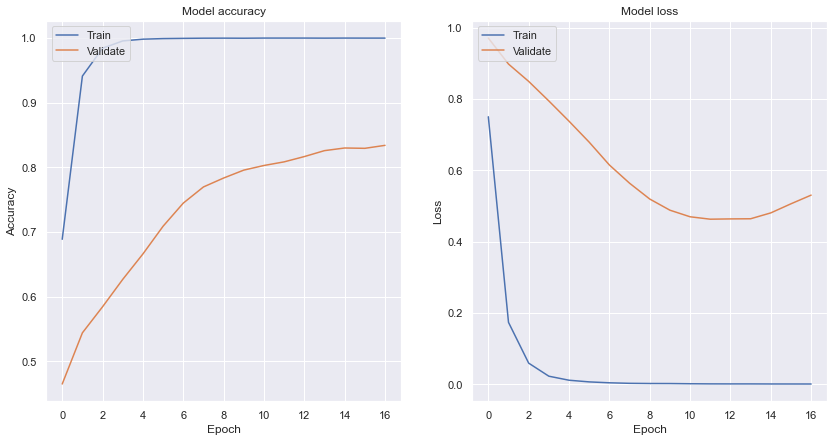

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               7783500   
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 300)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 9

In [13]:
plot_keras_history(model.history)
model.summary()

train set: logloss: 0.001
valid set: logloss: 0.530
train set
              precision    recall  f1-score   support

         EAP      1.000     1.000     1.000      7110
         HPL      1.000     1.000     1.000      5071
         MWS      1.000     1.000     1.000      5440

    accuracy                          1.000     17621
   macro avg      1.000     1.000     1.000     17621
weighted avg      1.000     1.000     1.000     17621

----------------------------------------------------------------------
validate set
              precision    recall  f1-score   support

         EAP      0.805     0.872     0.837       790
         HPL      0.897     0.787     0.839       564
         MWS      0.824     0.828     0.826       604

    accuracy                          0.834      1958
   macro avg      0.842     0.829     0.834      1958
weighted avg      0.837     0.834     0.834      1958



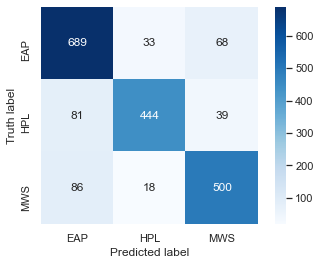

In [14]:
evaluate_model(model, 'FC Network+BoW', xtrain_enc, ytrain, xvalid_enc, yvalid, fit=None)

## 增加GloVec Embedding

In [15]:
# create an embedding matrix for the words we have in the dataset
embedding_width = len(embeddings_index['the'])
embedding_matrix = np.zeros((len(word_index) + 1, embedding_width))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print('shape of train matrix:', xtrain_enc.shape)
print('shape of embedding matrix:', embedding_matrix.shape)


shape of train matrix: (17621, 25944)
shape of embedding matrix: (25944, 300)


In [16]:
print(word_index['should'])
print(embedding_matrix[word_index['should']])

96
[-0.013048    0.066305   -0.18674999 -0.077878   -0.16395    -0.25972
  0.029303   -0.15825    -0.19078     2.8283     -0.163      -0.05534
  0.22109     0.21402    -0.15347999 -0.066198    0.010375    1.1365
 -0.38681999  0.25817001 -0.096464   -0.084158    0.076939   -0.30340001
 -0.030256    0.13372    -0.17986    -0.30307001  0.052078   -0.28134999
 -0.45357001 -0.05815     0.13801999  0.12679    -0.15589    -0.096631
 -0.041036   -0.0067604  -0.20026    -0.1105     -0.16964     0.13875
 -0.077402   -0.061383   -0.097824   -0.14076    -0.20308    -0.18849
 -0.28672999  0.15407    -0.13096    -0.032663    0.090106   -0.12916
  0.34599999 -0.018437   -0.011253   -0.35414001 -0.053053   -0.088397
 -0.30039999 -0.16288     0.088432    0.54714     0.45056     0.23582
 -0.24749     0.25558999  0.34963    -0.060627    0.0033251  -0.004153
  0.46325999 -0.010819    0.24965    -0.065957    0.14683001 -0.30344
  0.16347     0.16621999 -0.14835    -0.07946    -0.54354     0.015714
 -0.0787

In [17]:
x_train_embeddings = np.dot(xtrain_enc, embedding_matrix)
x_valid_embeddings = np.dot(xvalid_enc, embedding_matrix)
x_train_embeddings.shape

(17621, 300)

In [18]:
x = np.zeros_like(x_train_embeddings[0])
for idx, count in enumerate(xtrain_enc[0]):
    if count == 0: continue
    word = token.index_word[idx]
    if word not in embeddings_index: continue
    x += embeddings_index[word]
np.all(x == x_train_embeddings[0])

True

In [19]:
# create a simple 3 layer sequential neural net
model = Sequential()

model.add(LayerNormalization(input_shape=(300,)))

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(3))
model.add(Activation('softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy', ])

In [20]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
model.fit(
    x_train_embeddings, y=ytrain_enc, batch_size=512, epochs=100, 
    verbose=1, validation_data=(x_valid_embeddings, yvalid_enc), callbacks=[earlystop]
)

Train on 17621 samples, validate on 1958 samples
Epoch 1/100
17621/17621 [==============================] - 2s 122us/sample - loss: 1.0565 - categorical_accuracy: 0.5646 - val_loss: 0.8467 - val_categorical_accuracy: 0.6527
Epoch 2/100
17621/17621 [==============================] - 0s 14us/sample - loss: 0.8199 - categorical_accuracy: 0.6555 - val_loss: 0.8066 - val_categorical_accuracy: 0.6599
Epoch 3/100
17621/17621 [==============================] - 0s 16us/sample - loss: 0.7359 - categorical_accuracy: 0.6916 - val_loss: 0.7636 - val_categorical_accuracy: 0.7028
Epoch 4/100
17621/17621 [==============================] - 0s 9us/sample - loss: 0.6811 - categorical_accuracy: 0.7111 - val_loss: 0.7240 - val_categorical_accuracy: 0.7191
Epoch 5/100
17621/17621 [==============================] - 0s 16us/sample - loss: 0.6408 - categorical_accuracy: 0.7298 - val_loss: 0.6880 - val_categorical_accuracy: 0.7319
Epoch 6/100
17621/17621 [==============================] - 0s 15us/sample - loss:

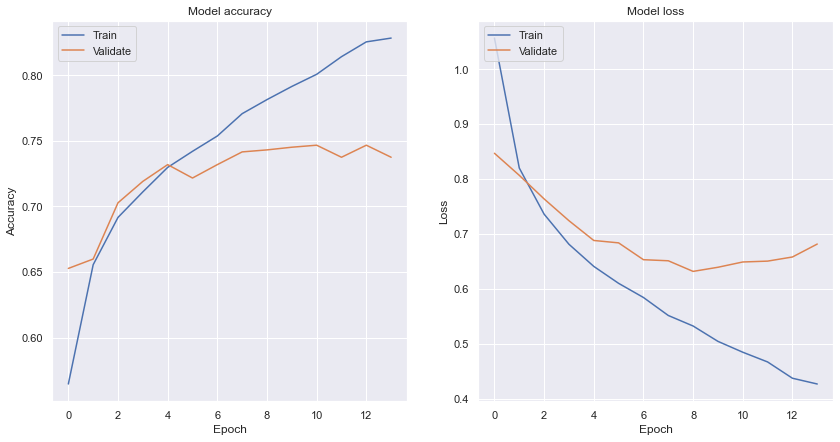

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_normalization (LayerNo (None, 300)               600       
_________________________________________________________________
dense_3 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 300)               1200      
_________________________________________________________________
dense_4 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_3 (Dropout)          (None, 300)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 300)              

In [21]:
plot_keras_history(model.history)
model.summary()

train set: logloss: 0.355
valid set: logloss: 0.681
train set
              precision    recall  f1-score   support

         EAP      0.835     0.905     0.869      7110
         HPL      0.894     0.841     0.867      5071
         MWS      0.886     0.837     0.861      5440

    accuracy                          0.866     17621
   macro avg      0.872     0.861     0.865     17621
weighted avg      0.868     0.866     0.866     17621

----------------------------------------------------------------------
validate set
              precision    recall  f1-score   support

         EAP      0.730     0.795     0.761       790
         HPL      0.740     0.723     0.732       564
         MWS      0.746     0.675     0.709       604

    accuracy                          0.737      1958
   macro avg      0.739     0.731     0.734      1958
weighted avg      0.738     0.737     0.737      1958



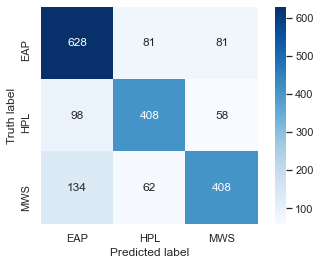

In [22]:
evaluate_model(model, 'FC Network+GloVec', x_train_embeddings, ytrain, x_valid_embeddings, yvalid, fit=None)

In [23]:
history

train            validate          
                    logloss  accuracy   logloss  accuracy
FC Network+BoW     0.000858  1.000000  0.530332  0.829067
FC Network+GloVec  0.354855  0.861187  0.681444  0.731279